<a href="https://colab.research.google.com/github/cda79/IAT360-LLM/blob/main/IAT360_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Required libraries

In [ ]:
!pip install transformers torch datasets

In [ ]:
!pip install transformers torch accelerate

##Data Pre-processing
Convert CSV to huggingface & gpt-2 format

**Import raw .csv data**

In [3]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("/content/shakespeare_dataset_2k.csv", encoding='latin-1')

# display it just to test
print(df.head())
df.info()

                                         shakespeare  \
0   I have a mind to strike thee ere thou speak'st .   
1  Yet if thou say Antony lives , is well , Or fr...   
2                                Madam , he's well .   
3                                        Well said .   
4                          And friends with Caesar .   

                                              modern  
0  I have half a mind to hit you before you speak...  
1  But if Antony is alive , healthy , friendly wi...  
2                                Madam , he's well .  
3                               That's well spoken .  
4                    And he's friendly with Caesar .  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   shakespeare  2301 non-null   object
 1   modern       2301 non-null   object
dtypes: object(2)
memory usage: 36.1+ KB


**Format it for gpt-2**

SOURCE: [Source Text] TARGET: [Target Text] <|endoftext|>

The <|endoftext|> token is for GPT-2 to signal the end of a generated sequence.


In [4]:
def format_translation_data(row):
  # whitespace cleanup
  shakespeare_text = row['shakespeare'].strip()
  modern_text = row['modern'].strip()
  formatted_text = f"SOURCE: {shakespeare_text} TARGET: {modern_text} <|endoftext|>"
  return formatted_text

# create new column for collated data to be tokenized
df['text_for_tokenization'] = df.apply(format_translation_data, axis=1)
# display it & check
print(df[['text_for_tokenization']].head())


                               text_for_tokenization
0  SOURCE: I have a mind to strike thee ere thou ...
1  SOURCE: Yet if thou say Antony lives , is well...
2  SOURCE: Madam , he's well . TARGET: Madam , he...
3  SOURCE: Well said . TARGET: That's well spoken...
4  SOURCE: And friends with Caesar . TARGET: And ...


Full display of the text for double checking since the previous output cuts it out

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

print(df[['text_for_tokenization']].to_string())

**Format for the Huggingface trainer**

In [5]:
hf_dataset = Dataset.from_pandas(df)
print("\nConverted to Hugging Face Dataset format.")
print(hf_dataset)


Converted to Hugging Face Dataset format.
Dataset({
    features: ['shakespeare', 'modern', 'text_for_tokenization'],
    num_rows: 2301
})


## Tokenization

**Define the tokenizer & apply**

Default gpt-2 padding & parameters.

To understand how gpt-2 tokenizes the text, [see here.](https://blog.lukesalamone.com/posts/gpt2-tokenization/)

In [6]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling

# gpt-2 tokenizer to make it machine readable
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# default padding token
tokenizer.pad_token = tokenizer.eos_token

# use the huggingface dataset we just converted
# hf_dataset = Dataset.from_pandas(df) << this was done in the previous step

def tokenize_function(examples):
    # uses the prepared 'text_for_tokenization' column
    return tokenizer(
        examples["text_for_tokenization"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )

# apply tokenization
# done by mapping it to the dataset and then removing the columns without tokens
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True, remove_columns=['shakespeare', 'modern', 'text_for_tokenization'])

# Display example tokenized output with the first entry
print("\n dataset structure:")
print(tokenized_datasets)
# where the input is decomposed into a string of numbers or tokens - depending on gpt-2s vocabulary
print(tokenized_datasets[0]["input_ids"])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/2301 [00:00<?, ? examples/s]


 dataset structure:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2301
})
[47690, 25, 314, 423, 257, 2000, 284, 5587, 17903, 304, 260, 14210, 2740, 338, 83, 764, 309, 46095, 25, 314, 423, 2063, 257, 2000, 284, 2277, 345, 878, 345, 2740, 757, 764, 220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

## Training

In [7]:
train_dataset = tokenized_datasets

# since we only have a test csv i just made it train on all the data
# otherwise we'd split it like this

#tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.1)
# or for 80/20 split, where seed is the randomizer
# ... = tokenized_datasets.train_test_split(train_size=0.8, seed=40)

**Load the model and adjust the parameters**

Loading and deploying the gpt-2 model based off tokenized data: https://medium.com/@majd.farah08/generating-text-with-gpt2-in-under-10-lines-of-code-5725a38ea685

Documentation for data collating: https://huggingface.co/docs/transformers/main/main_classes/data_collator

... and what it does internally / the different types: https://towardsdatascience.com/data-collators-in-huggingface-a0c76db798d2/

In [8]:
from transformers import TrainingArguments, Trainer
import torch

# load gpt-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# data collating allows us to use our csv datatables as the input for model
# the mlm specifies whether we should mask tokens or not - usually used for prediction
# when its set to false then the labels = inputs with the padding ignored
# so the whole thing is read AND it returns the labels which is important for our specific translation use
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# set up the trainer and its arguements
training_args = TrainingArguments(
    output_dir="./gpt2_shakespeare_translator",  # directory to save checkpoints
    num_train_epochs=3,                       # epoch size
    per_device_train_batch_size=4,             # batch size - the default is 8 batch size which then goes to 4
    logging_steps=200,                          # log the stats of the training every 10 steps, creates a consistent loss chart
)

# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
# training command
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 4-4-4-bossss (4-4-4-bossss-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
200,3.002300
400,2.832100
600,2.701300
800,2.397100
1000,2.373300
1200,2.304800
1400,2.182600
1600,2.139800


TrainOutput(global_step=1728, training_loss=2.469095159459997, metrics={'train_runtime': 617.2089, 'train_samples_per_second': 11.184, 'train_steps_per_second': 2.8, 'total_flos': 901849448448000.0, 'train_loss': 2.469095159459997, 'epoch': 3.0})

**Save newly trained model and reload it to replace the old one**

In [10]:
from transformers import GPT2LMHeadModel

# save model
trainer.save_model()
print(f"Model saved to {training_args.output_dir}")

#load it
model = GPT2LMHeadModel.from_pretrained(training_args.output_dir)
print("Trained model reloaded successfully.")

Model saved to ./gpt2_shakespeare_translator
Trained model reloaded successfully.


**Generate loss training chart for better visualization**

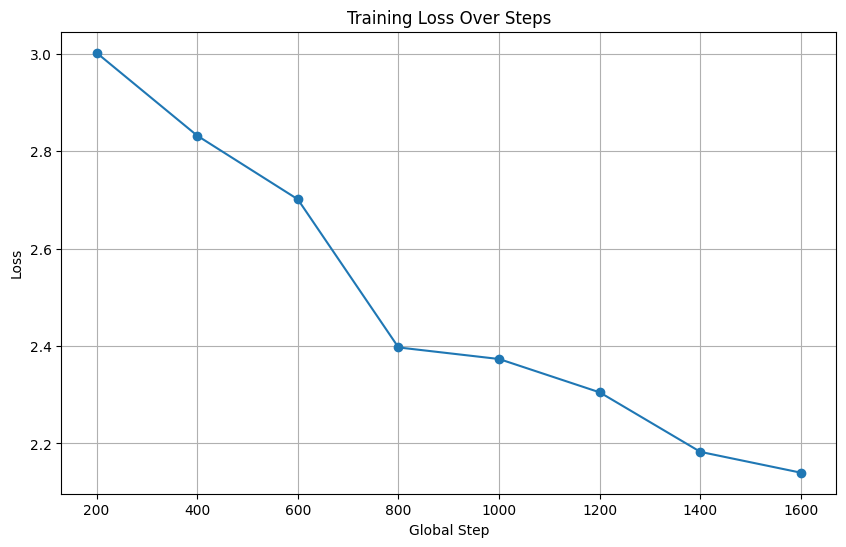

In [11]:
import matplotlib.pyplot as plt

if 'trainer' in locals() or 'trainer' in globals():
    log_history = trainer.state.log_history

    steps = []
    losses = []

    for entry in log_history:
        if 'loss' in entry and 'step' in entry: # Filter for step-wise logs
            steps.append(entry['step'])
            losses.append(entry['loss'])

    if steps and losses:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, marker='o', linestyle='-')
        plt.title('Training Loss Over Steps')
        plt.xlabel('Global Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    else:
        # If no step-wise loss was found, check for the final aggregated training_loss
        final_train_loss_entry = None
        for entry in log_history:
            if 'train_loss' in entry:
                final_train_loss_entry = entry
                break

        if final_train_loss_entry:
            print(f"Only the final training loss is available: {final_train_loss_entry['train_loss']} at step {final_train_loss_entry['step']}.")
            print("A graph requires multiple data points. To see loss progression, ensure 'logging_steps' is set appropriately in TrainingArguments and logs are accessible.")
            # Optionally, plot a single point if that's all there is
            plt.figure(figsize=(2, 2))
            plt.plot([final_train_loss_entry['step']], [final_train_loss_entry['train_loss']], marker='X', color='red', markersize=10)
            plt.title('Final Training Loss')
            plt.xlabel('Global Step')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.show()
        else:
            print("No training loss data found.")
else:
    print("The 'trainer' object was not found.")

## Deploy Model & Generate Text

Test model by using custom inputs and reviewing the outputs based on training.

###**Important**
the input sentence must end w/ "TARGET:" so the model can generate its response afterwards. This is how it tries to complete the entire sentence based off the patterns learned during training.


*   Where we formatted and collated the sentences to start with `SOURCE` and `TARGET` from before:
*   `formatted_text = f"SOURCE: {shakespeare_text} TARGET: {modern_text} <|endoftext|>"`




Generation part of the code and its parameters were based off the huggingface text documentation: https://huggingface.co/docs/transformers/en/main_classes/text_generation

as well as gemini's suggestions for what should be fine tuned

In [35]:
from transformers import pipeline

# huggingface pipeline library
generator = pipeline(
    'text-generation', # task
    model=model, # saved model
    tokenizer=tokenizer, # use previous established tokenizer
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

## INPUT PART !!!
input_shakespeare = "Good your highness, patience." #exact test from the training set to check it works, replace this later
prompt = f"SOURCE: {input_shakespeare} TARGET:" # actual formatted prompt the generator will be recieving

## generator parameters
output = generator(
    prompt, #prompt as input
    max_new_tokens=30, #output length
    num_return_sequences=1, # "The number of independently computed returned sequences for each element in the batch."
    do_sample=True, #generation strategy
    top_k=50, #probablity tokens, use 50 first most likely
    temperature=0.7, #randomness
    eos_token_id=tokenizer.eos_token_id # stop generation when the <|endoftext|> token is generated
)

## generated text extraction + stripping
generated_text = output[0]['generated_text']
# remove the PROMPT: text from the generated line and the end <|endoftext|> token
translation = generated_text.replace(prompt, '').replace(tokenizer.eos_token, '').strip()

## FINAL OUTPUT
print(f"\n--- Translation Output ---")
print(f"Input Prompt: {input_shakespeare}")
print(f"Generated Modern English: {translation}")




Device set to use cuda:0



--- Translation Output ---
Input Prompt: Good your highness, patience.
Generated Modern English: Good your highness, calm down. ~~~ ~~~ ~~~ ~~~ ~~~~~~~ ~~~~~~~ ~~~~
